# Cerebellar volumetry analysis with GLM
## Data: 
    - 1. Freesurfer results: ICV. Lh/Rh_cerebellum_gm/wm (generated by "collect_volumes.sh" script);
        - Left/ Right cerebellum gray/white matter volumes 
    - 2. Cerebellar SUIT segmentation with SUIT and MDTB atlas; 
         - SUIT: Vermis VI, Vermis_CrusI,  Vermis_CrusII, CrusI, CrusII, Dentate nucleus;
         - MBTB: MDTB functional regions 1,2,4,5;
    - 3. Cerebellar MAGeTBrain [MAGeTBrain pipeline](https://github.com/CobraLab/documentation/wiki/MAGeTBrain#collecting-volumes)
        - MAGeT: Vermis VI, Vermis_CrusI,  Vermis_CrusII, CrusI, CrusII, Dentate nucleus;

## Cohorts
- Current cohort: MNI ET/NC (38/32)(34/29PassQC), PPMI/ADNI NC (116/308) (78/223PassQC).

## Tasks: GLM analysis for: 
- Comparing cerebellar volumes (left/right GM/WM)
- Compare lobular volumes ['Vermis_VI', 'Vermis_CrusI', 'Vermis_CrusII'; 'Left_CrusI', 'Right_CrusI', 'Left_CrusII', 'Right_CrusII'; 'Left_Dentate', 'Right_Dentate'; 
                'MDTB_1', 'MDTB_2', 'MDTB_4', 'MDTB_5'];

## Covariates
- Age, Sex, intracranial volume (eTIV, infratentorium, cerebellar volume), site.

In [1]:
## read demographic data and freesurfer outputs
from pathlib import Path
import nipype.interfaces.io as nio
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data_dir = Path("/codes/tab_data")
data_all_file  = data_dir/'all_Des-cere_preped_qcInfo.csv'
matched_data_file = data_dir/'matched_Des-cere_qced.csv'
data_df    = pd.read_csv(data_all_file , sep=',', header=0, index_col=0);
matched_df = pd.read_csv(matched_data_file , sep=',', header=0, index_col=0);

In [2]:
# prepare data for this script
SUIT_labels = ['Left_I_IV','Right_I_IV','Left_V','Right_V','Left_VI','Vermis_VI','Right_VI','Left_CrusI','Vermis_CrusI','Right_CrusI','Left_CrusII','Vermis_CrusII','Right_CrusII','Left_VIIb','Vermis_VIIb','Right_VIIb','Left_VIIIa','Vermis_VIIIa','Right_VIIIa','Left_VIIIb','Vermis_VIIIb','Right_VIIIb','Left_IX','Vermis_IX','Right_IX','Left_X','Vermis_X','Right_X','Left_Dentate','Right_Dentate','Left_Interposed','Right_Interposed','Left_Fastigial','Right_Fastigial'];
SUIT_labels = [ x.replace('-','_') for x in SUIT_labels]
SUIT_l_labels = ['Left_I_IV',  'Left_V', 'Left_VI', 'Left_CrusI', 'Left_CrusII', 'Left_VIIb', 'Left_VIIIa', 'Left_VIIIb', 'Left_IX', 'Left_X', 'Left_Dentate', 'Left_Interposed', 'Left_Fastigial'];
SUIT_r_labels = ['Right_I_IV','Right_V','Right_VI','Right_CrusI','Right_CrusII','Right_VIIb','Right_VIIIa','Right_VIIIb','Right_IX','Right_X','Right_Dentate','Right_Interposed','Right_Fastigial'];
SUIT_v_labels = ['Vermis_VI', 'Vermis_CrusI', 'Vermis_CrusII', 'Vermis_VIIb', 'Vermis_VIIIa','Vermis_VIIIb', 'Vermis_IX', 'Vermis_X'];
MDTB_labels   = ['MDTB_'+str(x+1) for x in range(10)];
qc_list = ['freesurfer_score', 'suit_score', 'maget_score']
analysis_list = ['age','sex','group','site','eTIV','SupraTentorialVol', 'SupraTentorialVolNotVent',
                 'Left_Cerebellum_White_Matter','Left_Cerebellum_Cortex','Right_Cerebellum_White_Matter','Right_Cerebellum_Cortex']+SUIT_l_labels+SUIT_r_labels+SUIT_v_labels+MDTB_labels+qc_list;
# select and create new cols
curr_df = data_df.loc[:,analysis_list]
curr_df.loc[:,'Cerebellum_White_Matter']=curr_df['Left_Cerebellum_White_Matter']+curr_df['Right_Cerebellum_White_Matter'];
curr_df.loc[:,'Cerebellum_Cortex']=curr_df['Left_Cerebellum_Cortex']+curr_df['Right_Cerebellum_Cortex'];
curr_df.loc[:,'cerebellumVol']=curr_df['Cerebellum_Cortex']+curr_df['Cerebellum_White_Matter']
# calculate the Infra tentorium volumen approximately by eTIV-SupraTentorialVol
curr_df.loc[:,'InfraTentorialVol']=curr_df['eTIV']-curr_df['SupraTentorialVol']
curr_df.loc[:,'male']=[int(x=='M') for x in curr_df['sex']]

In [3]:
### statistical analysis
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils_et_biomarker.utils import ctr_tiv, glm_test, rep_model, ctr_by_nc, cal_es,creat_Bonf_df

# get the MNI dataset for ET/NC analysis
df_mni = curr_df[(curr_df['group']=='ET')|(curr_df['group']=='NC')].copy()

# get all 3 datasets for ET/NC analysis
df_all=curr_df.copy()
df_all.loc[:,'is_mni'] =[1 if int(x=='ET' or x=='NC') else 0 for x in df_all['group']]
df_all.loc[:,'is_ppmi']=[int(x=='PPMI') for x in df_all['group']]
df_all.loc[:,'is_adni']=[int(x=='ADNI') for x in df_all['group']]
df_all.loc[:,'cohort']=df_all.loc[:,'group'].copy()
df_all.loc[:,'cohort'] = ['MNI' if x=='ET' or x=='NC' else x for x in df_all.loc[:,'cohort']]
df_all.loc[:,'group']  =[x if x=='ET' else 'NC' for x in df_all['group']]

## covariates and target labels
info_list=['age','sex','group','site','eTIV','SupraTentorialVol', 'SupraTentorialVolNotVent','InfraTentorialVol']
cerebellum_list = ['Left_Cerebellum_Cortex','Left_Cerebellum_White_Matter',
                   'Right_Cerebellum_Cortex','Right_Cerebellum_White_Matter',
                   'Cerebellum_Cortex','Cerebellum_White_Matter'];
lobular_list = ['Vermis_VI', 'Vermis_CrusI', 'Vermis_CrusII', 
                'Left_CrusI', 'Right_CrusI', 'Left_CrusII', 'Right_CrusII','Left_Dentate', 'Right_Dentate',
                'MDTB_1', 'MDTB_2', 'MDTB_4', 'MDTB_5'];
tar_list = cerebellum_list+lobular_list;

df_n_comp=pd.DataFrame(zip(cerebellum_list+lobular_list, [4,4,4,4,2,2, 9,9,9,9,9,9,9,9,9, 4,4,4,4]), 
                       index=cerebellum_list+lobular_list, columns=['ROI','n_comp'])

# Applying QC: 1. ET: 38 -> 34; 2. NC: 32 -> 29; 3. ADNI: 309 -> 223; 4. PPMI: 116 -> 78;
qc_th=2
df_mni_qc=df_mni[(df_mni['freesurfer_score']>=qc_th)&(df_mni['suit_score']>=qc_th)&(df_mni['maget_score']>=qc_th)];
df_all_qc=df_all[(df_all['freesurfer_score']>=qc_th)&(df_all['suit_score']>=qc_th)&(df_all['maget_score']>=qc_th)]

,eTIV,SupraTentorialVol,InfraTentorialVol,cerebellumVol
eTIV,1.000000,0.718239,0.807257,0.521469
SupraTentorialVol,0.718239,1.000000,0.169144,0.530542
InfraTentorialVol,0.807257,0.169144,1.000000,0.288633
cerebellumVol,0.521469,0.530542,0.288633,1.000000


,eTIV,SupraTentorialVol,InfraTentorialVol,cerebellumVol
eTIV,1.000000,0.841576,0.794829,0.580482
SupraTentorialVol,0.841576,1.000000,0.341134,0.696672
InfraTentorialVol,0.794829,0.341134,1.000000,0.227529
cerebellumVol,0.580482,0.696672,0.227529,1.000000


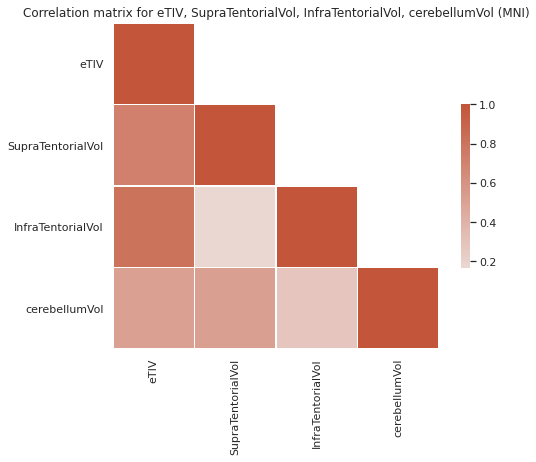

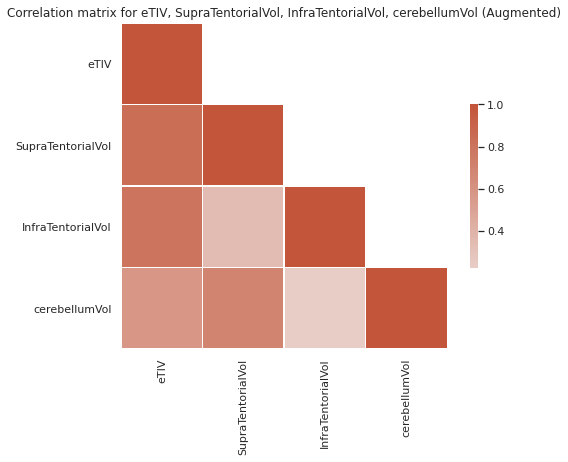

In [4]:
# report correlation between the intracranial volumes for controling
import matplotlib.pyplot as plt
vol_list = ['eTIV', 'SupraTentorialVol', 'InfraTentorialVol', 'cerebellumVol'];
sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# MNI dataset
corr_df=df_mni_qc[vol_list]
corr_=corr_df.corr()
mask = np.triu(np.ones_like(corr_, dtype=bool), k=1)
f, ax = plt.subplots(figsize=(8, 6))
ax=sns.heatmap(corr_, mask=mask, cmap=cmap, vmax=1, center=0, xticklabels=vol_list, yticklabels=vol_list,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title('Correlation matrix for eTIV, SupraTentorialVol, InfraTentorialVol, cerebellumVol (MNI)')
display(corr_)
# Augmented dataset
corr_df=df_all_qc[vol_list]
corr_=corr_df.corr()
mask = np.triu(np.ones_like(corr_, dtype=bool), k=1)
f, ax = plt.subplots(figsize=(8, 6))
ax=sns.heatmap(corr_, mask=mask, cmap=cmap, vmax=1, center=0, xticklabels=vol_list, yticklabels=vol_list,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title('Correlation matrix for eTIV, SupraTentorialVol, InfraTentorialVol, cerebellumVol (Augmented)')
display(corr_)

# GLM analysis for MNI dataset ET/NC before and after QC (38/32)->(34/29)

1. Testing Models: Voi=b0+b1*age+b2*sex+b3*eIV+b4*group for 'Left_Cerebellum_Cortex', 'Left_Cerebellum_White_Matter', 'Right_Cerebellum_Cortex', 'Right_Cerebellum_White_Matter'; 

2. Testing Models: Voi=b0+b1*age+b2*sex+b3*eIV+b4*group for 'Vermis_VI', 'Vermis_CrusI', 'Vermis_CrusII', 'Left_CrusI', 'Right_CrusI', 'Left_CrusII', 'Right_CrusII','Left_Dentate', 'Right_Dentate', 'MDTB_1', 'MDTB_2', 'MDTB_4', 'MDTB_5';

In [5]:
# GLM for cerebellum volumetry before and after QC for MNI cohort controling difference intracranial volumes (age/sex/eTIV)
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import glm
import statsmodels.stats as sts
from utils_et_biomarker.utils import glm_test, rep_model

alpha_=0.05

print("GLM for cerebellum volumetry (age/sex/eTIV) on MNI cohort before and after QC:")
# Before QC (age/sex/eTIV)
tmp_df = df_mni.copy() 
covariate_model_str = '~age+C(sex, Treatment(reference="F"))+eTIV+C(group, Treatment(reference="NC"))';
covariate_dict = glm_test(tmp_df, tar_list, covariate_model_str);
print('Before QC (age/sex/eTIV):')
rep_model(covariate_dict, {'name':'significant','col_name':'C(group, Treatment(reference="NC"))[T.ET]','th':alpha_});
#rep_model(covariate_dict,{'name':'all'});

# After QC (age/sex/eTIV)
tmp_qc_df = df_mni_qc.copy()
covariate_dict_qc = glm_test(tmp_qc_df, tar_list, covariate_model_str);
print('After QC (age/sex/eTIV):')
rep_model(covariate_dict_qc, {'name':'significant','col_name':'C(group, Treatment(reference="NC"))[T.ET]','th':alpha_});
#rep_model(covariate_dict,{'name':'all'});

# GLM for cerebellum volumetry (age/sex/InfraTentorialVol) on MNI cohort before and after QC
print("GLM for cerebellum volumetry (age/sex/InfraTentorialVol) on MNI cohort before and after QC:")
# Before QC (age/sex/InfraTentorialVol)
print('Before QC (age/sex/InfraTentorialVol):')
covariate_model_str_infra = '~age+C(sex, Treatment(reference="F"))+InfraTentorialVol+C(group, Treatment(reference="NC"))';
covariate_dict_infra = glm_test(tmp_df, tar_list, covariate_model_str_infra);
rep_model(covariate_dict_infra,{'name':'significant','col_name':'C(group, Treatment(reference="NC"))[T.ET]','th':alpha_});
#rep_model(covariate_dict,{'name':'all'});

# After QC (age/sex/InfraTentorialVol)
print('After QC (age/sex/InfraTentorialVol):')
covariate_dict_infra = glm_test(tmp_qc_df, tar_list, covariate_model_str_infra);
rep_model(covariate_dict_infra,{'name':'significant','col_name':'C(group, Treatment(reference="NC"))[T.ET]','th':alpha_});
#rep_model(covariate_dict,{'name':'all'});

# GLM for cerebellum volumetry (age/sex/cerebellumVol) on MNI cohort before and after QC
print("GLM for cerebellum volumetry (age/sex/cerebellumVol) on MNI cohort before and after QC:")
# Before QC (age/sex/cerebellumVol)
print('Before QC (age/sex/cerebellumVol):')
covariate_model_str_cere = '~age+C(sex, Treatment(reference="F"))+cerebellumVol+C(group, Treatment(reference="NC"))';
covariate_dict_cere = glm_test(tmp_df, tar_list, covariate_model_str_cere);
rep_model(covariate_dict_cere,{'name':'significant','col_name':'C(group, Treatment(reference="NC"))[T.ET]','th':alpha_});
#rep_model(covariate_dict,{'name':'all'});

# After QC (age/sex/cerebellumVol)
print('After QC (age/sex/cerebellumVol):')
covariate_dict_cere = glm_test(tmp_qc_df, tar_list, covariate_model_str_cere);
rep_model(covariate_dict_cere,{'name':'significant','col_name':'C(group, Treatment(reference="NC"))[T.ET]','th':alpha_});
#rep_model(covariate_dict,{'name':'all'});

GLM for cerebellum volumetry (age/sex/eTIV) on MNI cohort before and after QC:
Before QC (age/sex/eTIV):
Only display significant results @ 0.05  for  C(group, Treatment(reference="NC"))[T.ET]  :

After QC (age/sex/eTIV):
Only display significant results @ 0.05  for  C(group, Treatment(reference="NC"))[T.ET]  :



Left_CrusI~age+C(sex, Treatment(reference="F"))+eTIV+C(group, Treatment(reference="NC")) 

                               Results: Generalized linear model
Model:                        GLM                        AIC:                      1058.4645    
Link Function:                identity                   BIC:                      62304709.6111
Dependent Variable:           Left_CrusI                 Log-Likelihood:           -524.23      
Date:                         2021-11-26 06:29           LL-Null:                  -551.37      
No. Observations:             63                         Deviance:                 6.2305e+07   
Df Model:                     4            

# GLM analysis for matched dataset ET/NC (34/) (QC pass:34/219 )


1. Testing Models: Voi=b0+b1*age+b2*sex+b3*eIV+b4*group for 'Left_Cerebellum_Cortex', 'Left_Cerebellum_White_Matter', 'Right_Cerebellum_Cortex', 'Right_Cerebellum_White_Matter'; 

2. Testing Models: Voi=b0+b1*age+b2*sex+b3*eIV+b4*group for 'Vermis_VI', 'Vermis_CrusI', 'Vermis_CrusII', 'Left_CrusI', 'Right_CrusI', 'Left_CrusII', 'Right_CrusII','Left_Dentate', 'Right_Dentate', 'MDTB_1', 'MDTB_2', 'MDTB_4', 'MDTB_5';

In [7]:
# GLM for cerebellum volumetry in matched dataset (age/sex/intracranialVol/group/cohort)
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import glm
import statsmodels.stats as sts
from utils_et_biomarker.utils import glm_test, rep_model

alpha_=0.05

print("GLM for cerebellum volumetry (age/sex/eTIV) on matched cohort:")
# 1.GLM for cerebellum volumetry with covariates:  age/sex/cohort/group/eTIV
tmp_df = matched_df.copy() 
covariate_model_all_str = '~age+C(sex, Treatment(reference="F"))+eTIV+C(cohort, Treatment(reference="MNI"))+C(group, Treatment(reference="NC"))';
covariate_dict = glm_test(tmp_df, tar_list, covariate_model_all_str);
rep_model(covariate_dict, {'name':'significant','col_name':'C(group, Treatment(reference="NC"))[T.ET]','th':alpha_});

# 2. GLM for cerebellum volumetry with covariates: age/sex/cohort/group/InfraTentorialVol.
print("GLM for cerebellum volumetry (age/sex/InfraTentorialVol) on matched cohort:")
covariate_model_str_infra = '~age+C(sex, Treatment(reference="F"))+InfraTentorialVol+C(cohort, Treatment(reference="MNI"))+C(group, Treatment(reference="NC"))';
covariate_dict_infra = glm_test(tmp_df, tar_list, covariate_model_str_infra);
rep_model(covariate_dict_infra,{'name':'significant','col_name':'C(group, Treatment(reference="NC"))[T.ET]','th':alpha_});

# 2. GLM for cerebellum volumetry with covariates: age/sex/cohort/group/cerebellumVol.
print("GLM for cerebellum volumetry (age/sex/cerebellumVol) on matched cohort:")
covariate_model_str_cere = '~age+C(sex, Treatment(reference="F"))+cerebellumVol+C(cohort, Treatment(reference="MNI"))+C(group, Treatment(reference="NC"))';
covariate_dict_cere = glm_test(tmp_df, tar_list, covariate_model_str_cere);
rep_model(covariate_dict_cere, {'name':'significant','col_name':'C(group, Treatment(reference="NC"))[T.ET]','th':alpha_});


GLM for cerebellum volumetry (age/sex/eTIV) on matched cohort:
Only display significant results @ 0.05  for  C(group, Treatment(reference="NC"))[T.ET]  :



Left_Cerebellum_White_Matter~age+C(sex, Treatment(reference="F"))+eTIV+C(cohort, Treatment(reference="MNI"))+C(group, Treatment(reference="NC")) 

                                  Results: Generalized linear model
Model:                      GLM                                 AIC:                   4541.2537     
Link Function:              identity                            BIC:                   875052459.3804
Dependent Variable:         Left_Cerebellum_White_Matter        Log-Likelihood:        -2263.6       
Date:                       2021-11-26 06:37                    LL-Null:               -2313.4       
No. Observations:           253                                 Deviance:              8.7505e+08    
Df Model:                   6                                   Pearson chi2:          8.75e+08      
Df Residuals:   

# GLM analysis for augmented dataset ET/NC (38/32+116+308) (QC pass:34/29+223+78)


1. Testing Models: Voi=b0+b1*age+b2*sex+b3*eIV+b4*group for 'Left_Cerebellum_Cortex', 'Left_Cerebellum_White_Matter', 'Right_Cerebellum_Cortex', 'Right_Cerebellum_White_Matter'; 

2. Testing Models: Voi=b0+b1*age+b2*sex+b3*eIV+b4*group for 'Vermis_VI', 'Vermis_CrusI', 'Vermis_CrusII', 'Left_CrusI', 'Right_CrusI', 'Left_CrusII', 'Right_CrusII','Left_Dentate', 'Right_Dentate', 'MDTB_1', 'MDTB_2', 'MDTB_4', 'MDTB_5';

In [8]:
# GLM for cerebellum volumetry before and after QC for Aug-cohort controling difference intracranial volumes (age/sex/eTIV)
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import glm
import statsmodels.stats as sts
from utils_et_biomarker.utils import glm_test, rep_model

alpha_=0.05

print("GLM for cerebellum volumetry (age/sex/eTIV) on Augmented cohort before and after QC:")
# Before QC (age/sex/eTIV)
tmp_df = df_all.copy() 

covariate_model_all_str = '~age+C(sex, Treatment(reference="F"))+eTIV+C(cohort, Treatment(reference="MNI"))+C(group, Treatment(reference="NC"))';
covariate_dict = glm_test(tmp_df, tar_list, covariate_model_all_str);
print('Before QC (age/sex/eTIV):')
rep_model(covariate_dict, {'name':'significant','col_name':'C(group, Treatment(reference="NC"))[T.ET]','th':alpha_});
#rep_model(covariate_dict,{'name':'all'});

# After QC (age/sex/eTIV)
tmp_qc_df = df_all_qc.copy()
covariate_dict_qc = glm_test(tmp_qc_df, tar_list, covariate_model_all_str);
print('After QC (age/sex/eTIV):')
rep_model(covariate_dict_qc, {'name':'significant','col_name':'C(group, Treatment(reference="NC"))[T.ET]','th':alpha_});
#rep_model(covariate_dict,{'name':'all'});

# GLM for cerebellum volumetry (age/sex/InfraTentorialVol) on MNI cohort before and after QC
print("GLM for cerebellum volumetry (age/sex/InfraTentorialVol) on Augmented cohort before and after QC:")
# Before QC (age/sex/InfraTentorialVol)
print('Before QC (age/sex/InfraTentorialVol):')
covariate_model_str_infra = '~age+C(sex, Treatment(reference="F"))+InfraTentorialVol+C(cohort, Treatment(reference="MNI"))+C(group, Treatment(reference="NC"))';
covariate_dict_infra = glm_test(tmp_df, tar_list, covariate_model_str_infra);
rep_model(covariate_dict_infra,{'name':'significant','col_name':'C(group, Treatment(reference="NC"))[T.ET]','th':alpha_});
#rep_model(covariate_dict,{'name':'all'});

# After QC (age/sex/InfraTentorialVol)
print('After QC (age/sex/InfraTentorialVol):')
covariate_dict_infra = glm_test(tmp_qc_df, tar_list, covariate_model_str_infra);
rep_model(covariate_dict_infra,{'name':'significant','col_name':'C(group, Treatment(reference="NC"))[T.ET]','th':alpha_});
#rep_model(covariate_dict,{'name':'all'});

# GLM for cerebellum volumetry (age/sex/cerebellumVol) on MNI cohort before and after QC
print("GLM for cerebellum volumetry (age/sex/cerebellumVol) on Augmented cohort before and after QC:")
# Before QC (age/sex/cerebellumVol)
print('Before QC (age/sex/cerebellumVol):')
covariate_model_str_cere = '~age+C(sex, Treatment(reference="F"))+cerebellumVol+C(cohort, Treatment(reference="MNI"))+C(group, Treatment(reference="NC"))';
covariate_dict_cere = glm_test(tmp_df, tar_list, covariate_model_str_cere);
rep_model(covariate_dict_cere, {'name':'significant','col_name':'C(group, Treatment(reference="NC"))[T.ET]','th':alpha_});
#rep_model(covariate_dict,{'name':'all'});

# After QC (age/sex/cerebellumVol)
print('After QC (age/sex/cerebellumVol):')
covariate_dict_cere = glm_test(tmp_qc_df, tar_list, covariate_model_str_cere);
rep_model(covariate_dict_cere, {'name':'significant','col_name':'C(group, Treatment(reference="NC"))[T.ET]','th':alpha_});
#rep_model(covariate_dict,{'name':'all'});

GLM for cerebellum volumetry (age/sex/eTIV) on Augmented cohort before and after QC:
Before QC (age/sex/eTIV):
Only display significant results @ 0.05  for  C(group, Treatment(reference="NC"))[T.ET]  :

After QC (age/sex/eTIV):
Only display significant results @ 0.05  for  C(group, Treatment(reference="NC"))[T.ET]  :

GLM for cerebellum volumetry (age/sex/InfraTentorialVol) on Augmented cohort before and after QC:
Before QC (age/sex/InfraTentorialVol):
Only display significant results @ 0.05  for  C(group, Treatment(reference="NC"))[T.ET]  :

After QC (age/sex/InfraTentorialVol):
Only display significant results @ 0.05  for  C(group, Treatment(reference="NC"))[T.ET]  :

GLM for cerebellum volumetry (age/sex/cerebellumVol) on Augmented cohort before and after QC:
Before QC (age/sex/cerebellumVol):
Only display significant results @ 0.05  for  C(group, Treatment(reference="NC"))[T.ET]  :

After QC (age/sex/cerebellumVol):
Only display significant results @ 0.05  for  C(group, Treatment(r

In [9]:
#rep_model(covariate_dict, {'name':'all','col_name':'C(group, Treatment(reference="NC"))[T.ET]','th':alpha_});